In [2]:
"""
Clean and preprocess Student_performance_data.csv for BrightPath Academy.
Produces a cleaned dataset and a summary report with data inspection, missing values,
outlier treatment, and distributions.
"""

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
from IPython.display import display
import xgboost as xgb

# Configuration
DATA_FILE = 'DataSets/Student_performance_data .csv'
CLEANED_FILE = 'DataSets/cleaned_student_performance_data.csv'
REPORT_FILE = 'initial_summary_report.txt'
PLOT_DIR = Path("plots")
IQR_MULTIPLIER = 1.5
NUMERIC_COLS = ["StudyTimeWeekly", "Absences", "GPA"]
CATEGORICAL_COLS = [
    "Gender",
    "Ethnicity",
    "ParentalEducation",
    "Tutoring",
    "ParentalSupport",
    "Extracurricular",
    "Sports",
    "Music",
    "Volunteering",
    "GradeClass",
]

# Debug: Print working directory and file paths
print(f"Current working directory: {os.getcwd()}")
print(f"Input file path: {Path(DATA_FILE).absolute()}")
print(f"Output file path: {Path(CLEANED_FILE).absolute()}")

def setup_environment() -> None:
    """Set up libraries and visualization settings."""
    try:
        sns.set_style("whitegrid")
        plt.rcParams["figure.figsize"] = (8, 6)
        PLOT_DIR.mkdir(exist_ok=True)
        print("Environment setup complete.")
    except Exception as e:
        print(f"Error setting up environment: {e}")
        raise

def load_and_inspect_data(file_path: str) -> pd.DataFrame:
    """
    Load dataset and perform initial inspection.
    
    Args:
        file_path (str): Path to CSV file.
        
    Returns:
        pd.DataFrame: Loaded dataset.
        
    Raises:
        FileNotFoundError: If CSV file is missing.
        Exception: For other loading errors.
    """
    try:
        data = pd.read_csv(file_path)
        print("First 5 rows of the dataset:")
        print(data.head())
        print("\nData Info:")
        print(data.info())
        print("\nBasic Statistics:")
        print(data.describe())
        
        with open(REPORT_FILE, "w") as report:
            report.write("Initial Summary Report\n" + "=" * 50 + "\n\n")
            report.write("First 5 Rows:\n" + str(data.head()) + "\n\n")
            report.write("Data Info:\n")
            data.info(buf=report)
            report.write("\n\nBasic Statistics:\n" + str(data.describe()) + "\n\n")
        
        return data
    except FileNotFoundError:
        print(f"Error: {file_path} not found. Please ensure it exists in {os.getcwd()}")
        raise
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

def handle_missing_values(
    data: pd.DataFrame, numeric_cols: list, categorical_cols: list
) -> pd.DataFrame:
    """
    Check and impute missing values.
    
    Args:
        data (pd.DataFrame): Input dataset.
        numeric_cols (list): Numeric column names.
        categorical_cols (list): Categorical column names.
        
    Returns:
        pd.DataFrame: Dataset with imputed values.
    """
    try:
        print("\nMissing Values:")
        missing = data.isnull().sum()
        print(missing)
        
        imputation_log = []
        for col in numeric_cols:
            if missing[col] > 0:
                median_value = data[col].median()
                data[col] = data[col].fillna(median_value)
                imputation_log.append(f"Imputed {col} with median: {median_value}")
        
        for col in categorical_cols:
            if missing[col] > 0:
                mode_value = data[col].mode()[0]
                data[col] = data[col].fillna(mode_value)
                imputation_log.append(f"Imputed {col} with mode: {mode_value}")
        
        if imputation_log:
            print("Imputation Summary:")
            for log in imputation_log:
                print(log)
        
        print("\nMissing Values After Imputation:")
        print(data.isnull().sum())
        
        with open(REPORT_FILE, "a") as report:
            report.write("Missing Values Check:\n" + str(missing) + "\n")
            if imputation_log:
                report.write("Imputation Summary:\n" + "\n".join(imputation_log) + "\n")
            report.write("\nMissing Values After:\n" + str(data.isnull().sum()) + "\n\n")
        
        return data
    except Exception as e:
        print(f"Error handling missing values: {e}")
        raise

def cap_outliers(series: pd.Series, multiplier: float = 1.5) -> pd.Series:
    """
    Cap outliers using IQR method.
    
    Args:
        series (pd.Series): Input column.
        multiplier (float): IQR multiplier for bounds.
        
    Returns:
        pd.Series: Capped column.
    """
    try:
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        return series.clip(lower_bound, upper_bound)
    except Exception as e:
        print(f"Error capping outliers: {e}")
        raise

def plot_boxplots(
    data: pd.DataFrame, cols: list, title: str, filename: str
) -> None:
    """
    Generate and save boxplots.
    
    Args:
        data (pd.DataFrame): Input dataset.
        cols (list): Columns to plot.
        title (str): Plot title.
        filename (str): Output file name.
    """
    try:
        n_cols = len(cols)
        fig, axes = plt.subplots(1, n_cols, figsize=(4 * n_cols, 4))
        if n_cols == 1:
            axes = [axes]
        for ax, col in zip(axes, cols):
            sns.boxplot(y=data[col], ax=ax)
            ax.set_title(f"{col}")
        fig.suptitle(title)
        plt.tight_layout()
        plt.savefig(PLOT_DIR / filename)
        plt.close()
        print(f"Saved plot: {PLOT_DIR / filename}")
    except Exception as e:
        print(f"Error plotting boxplots: {e}")
        raise

def plot_distributions(
    data: pd.DataFrame, cols: list, title: str, filename: str
) -> None:
    """
    Generate and save histograms with KDE.
    
    Args:
        data (pd.DataFrame): Input dataset.
        cols (list): Columns to plot.
        title (str): Plot title.
        filename (str): Output file name.
    """
    try:
        n_cols = len(cols)
        n_rows = (n_cols + 1) // 2
        fig, axes = plt.subplots(n_rows, min(n_cols, 2), figsize=(8, 4 * n_rows))
        axes = axes.flatten() if n_cols > 1 else [axes]
        for ax, col in zip(axes, cols):
            sns.histplot(data[col], kde=True, ax=ax)
            ax.set_title(f"{col}")
        if n_cols % 2:
            axes[-1].axis("off")
        fig.suptitle(title)
        plt.tight_layout()
        plt.savefig(PLOT_DIR / filename)
        plt.close()
        print(f"Saved plot: {PLOT_DIR / filename}")
    except Exception as e:
        print(f"Error plotting distributions: {e}")
        raise

def plot_categorical(
    data: pd.DataFrame, cols: list, title: str, filename: str
) -> None:
    """
    Generate and save count plots.
    
    Args:
        data (pd.DataFrame): Input dataset.
        cols (list): Columns to plot.
        title (str): Plot title.
        filename (str): Output file name.
    """
    try:
        n_cols = len(cols)
        n_rows = (n_cols + 1) // 2
        fig, axes = plt.subplots(n_rows, min(n_cols, 2), figsize=(8, 4 * n_rows))
        axes = axes.flatten() if n_cols > 1 else [axes]
        for ax, col in zip(axes, cols):
            sns.countplot(x=data[col], ax=ax)
            ax.set_title(f"{col}")
        if n_cols % 2:
            axes[-1].axis("off")
        fig.suptitle(title)
        plt.tight_layout()
        plt.savefig(PLOT_DIR / filename)
        plt.close()
        print(f"Saved plot: {PLOT_DIR / filename}")
    except Exception as e:
        print(f"Error plotting categorical: {e}")
        raise

def main():
    """Main function to clean and preprocess dataset."""
    try:
        setup_environment()
        
        # Load and inspect
        data = load_and_inspect_data(DATA_FILE)
        
        # Handle missing values
        data = handle_missing_values(data, NUMERIC_COLS, CATEGORICAL_COLS)
        
        # Handle outliers
        plot_boxplots(data, NUMERIC_COLS, "Boxplots Before Outlier Treatment", "outliers_before.png")
        for col in NUMERIC_COLS:
            data[col] = cap_outliers(data[col], IQR_MULTIPLIER)
            print(f"Outliers capped for {col}")
        plot_boxplots(data, NUMERIC_COLS, "Boxplots After Outlier Treatment", "outliers_after.png")
        
        with open(REPORT_FILE, "a") as report:
            report.write("Outlier Treatment:\n")
            report.write(f"Applied IQR-based capping (multiplier={IQR_MULTIPLIER}) to {', '.join(NUMERIC_COLS)}.\n")
            report.write("Visualizations saved as plots/outliers_before.png and plots/outliers_after.png.\n\n")
        
        # Plot distributions
        plot_distributions(data, NUMERIC_COLS, "Numeric Distributions", "distributions.png")
        selected_categorical = ["GradeClass", "Gender", "Ethnicity", "ParentalSupport"]
        plot_categorical(data, selected_categorical, "Categorical Distributions", "categorical_distributions.png")
        
        with open(REPORT_FILE, "a") as report:
            report.write("Distributions:\n")
            report.write(f"Numeric: {', '.join(NUMERIC_COLS)} saved in plots/distributions.png.\n")
            report.write(f"Categorical: {', '.join(selected_categorical)} saved in plots/categorical_distributions.png.\n\n")
        
        # Save cleaned dataset
        data.to_csv(CLEANED_FILE, index=False)
        print(f"Cleaned dataset saved as {CLEANED_FILE}")
        print(f"Saved at: {Path(CLEANED_FILE).absolute()}")
        
        # Finalize report
        with open(REPORT_FILE, "a") as report:
            report.write("Conclusion:\n")
            report.write(f"Dataset cleaned and saved as {CLEANED_FILE}.\n")
            report.write("All missing values handled and outliers capped.\n")
            report.write("Visualizations and summaries provided for further analysis.\n")
        
        print(f"Initial summary report saved as {REPORT_FILE}")
        print(f"Saved at: {Path(REPORT_FILE).absolute()}")
    except Exception as e:
        print(f"Error in main execution: {e}")
        raise

if __name__ == "__main__":
    main()


Current working directory: c:\Users\User\OneDrive\Desktop\MLG382_Project1
Input file path: c:\Users\User\OneDrive\Desktop\MLG382_Project1\DataSets\Student_performance_data .csv
Output file path: c:\Users\User\OneDrive\Desktop\MLG382_Project1\DataSets\cleaned_student_performance_data.csv
Environment setup complete.
First 5 rows of the dataset:
   StudentID  Age  Gender  Ethnicity  ParentalEducation  StudyTimeWeekly  \
0       1001   17       1          0                  2        19.833723   
1       1002   18       0          0                  1        15.408756   
2       1003   15       0          2                  3         4.210570   
3       1004   17       1          0                  3        10.028829   
4       1005   17       1          0                  2         4.672495   

   Absences  Tutoring  ParentalSupport  Extracurricular  Sports  Music  \
0         7         1                2                0       0      1   
1         0         0                1            

In [3]:
#load clean data set
df = pd.read_csv("DataSets/cleaned_student_performance_data.csv")

#extract features and define input and output variables
features = df.columns.drop("GradeClass").to_list()
x= df[features]
y= df["GradeClass"]

display(x,y)


,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2387,3388,18,1,0,3,10.680555,2,0,4,1,0,0,0,3.455509
2388,3389,17,0,0,1,7.583217,4,1,4,0,1,0,0,3.279150
2389,3390,16,1,0,2,6.805500,20,0,2,0,0,0,1,1.142333
2390,3391,16,1,1,0,12.416653,17,0,2,0,1,1,0,1.803297


0       2.0
1       1.0
2       4.0
3       3.0
4       4.0
       ... 
2387    0.0
2388    4.0
2389    2.0
2390    1.0
2391    1.0
Name: GradeClass, Length: 2392, dtype: float64

In [4]:
#model building
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=45)
display(x_test)

#Scaling the data to have a mean of 0 and standard deviation of 1
scaler = StandardScaler()

#creating copies of training and test data
X_train_scaled = x_train.copy()
X_test_scaled = x_test.copy()

X_train_scaled[['StudyTimeWeekly', 'Absences', 'GPA']] = scaler.fit_transform(x_train[['StudyTimeWeekly', 'Absences', 'GPA']])
X_test_scaled[['StudyTimeWeekly', 'Absences', 'GPA']] = scaler.transform(x_test[['StudyTimeWeekly', 'Absences', 'GPA']])

selected_features = ["StudyTimeWeekly", "GPA"]

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA
754,1755,16,1,2,2,16.436029,20,0,2,1,1,0,0,1.834227
1477,2478,18,1,0,3,11.677165,1,1,2,0,0,0,0,3.454462
30,1031,15,0,2,2,5.055317,12,1,0,0,1,0,0,1.727120
793,1794,18,1,1,4,17.902001,14,0,3,0,0,0,1,2.168642
1276,2277,15,1,0,2,13.896415,11,1,0,1,1,0,0,2.396139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2279,3280,17,0,2,2,5.125098,11,0,3,1,1,0,0,2.430091
433,1434,18,1,2,2,4.224165,19,0,3,0,1,1,0,1.548710
1090,2091,18,0,0,2,13.142377,27,1,4,0,1,0,0,0.963632
2305,3306,15,0,1,0,5.824466,19,0,3,0,1,0,0,1.361435


In [5]:
#Model 1 logistic regression

# Train and fit Logistic Regression model
model = LogisticRegression(max_iter=7000, solver='saga', C=0.1, random_state=45)
model.fit(X_train_scaled[["StudyTimeWeekly", "GPA"]], y_train)

# Predict
y_train_pred = model.predict(X_train_scaled[["StudyTimeWeekly", "GPA"]])
y_test_pred = model.predict(X_test_scaled[["StudyTimeWeekly", "GPA"]])


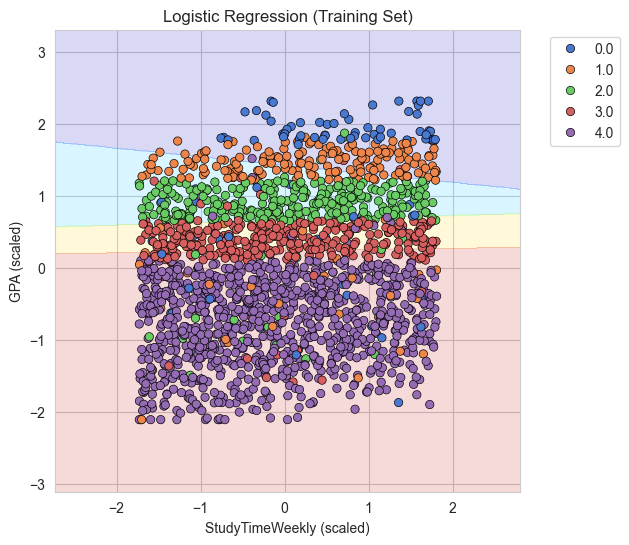

In [6]:
#Plotting the data training set
fig, ax = plt.subplots(figsize=(6, 6))
X1, X2 = np.meshgrid(
    np.arange(start=X_train_scaled["StudyTimeWeekly"].min() - 1, 
              stop=X_train_scaled["StudyTimeWeekly"].max() + 1, 
              step=0.01),
    np.arange(start=X_train_scaled["GPA"].min() - 1, 
              stop=X_train_scaled["GPA"].max() + 1, 
              step=0.01)
)
df_mesh = pd.DataFrame({
    "StudyTimeWeekly": X1.ravel(),
    "GPA": X2.ravel()
})
mesh_pred = model.predict(df_mesh)
ax.contourf(X1, X2, mesh_pred.reshape(X1.shape), alpha=0.15, cmap=plt.cm.jet)

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

df_train = X_train_scaled.copy()
df_train["GradeClass"] = y_train

sns.scatterplot(x="StudyTimeWeekly", 
                y="GPA", 
                hue="GradeClass", 
                data=df_train, 
                ax=ax, 
                edgecolor='black', 
                palette="muted")
plt.title('Logistic Regression (Training Set)')
plt.xlabel('StudyTimeWeekly (scaled)')
plt.ylabel('GPA (scaled)')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

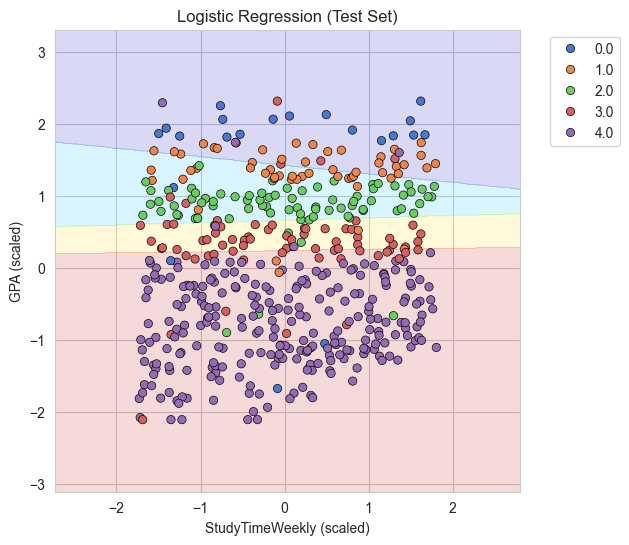

In [7]:
#Plotting the data test set
fig, ax = plt.subplots(figsize=(6, 6))
X1, X2 = np.meshgrid(
    np.arange(start=X_test_scaled["StudyTimeWeekly"].min() - 1, 
              stop=X_test_scaled["StudyTimeWeekly"].max() + 1, 
              step=0.01),
    np.arange(start=X_test_scaled["GPA"].min() - 1, 
              stop=X_test_scaled["GPA"].max() + 1, 
              step=0.01)
)
df_mesh = pd.DataFrame({
    "StudyTimeWeekly": X1.ravel(),
    "GPA": X2.ravel()
})

mesh_pred = model.predict(df_mesh)

ax.contourf(X1, X2, mesh_pred.reshape(X1.shape), 
            alpha=0.15, 
            cmap=plt.cm.jet)

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

df_test = X_test_scaled.copy()
df_test["GradeClass"] = y_test

sns.scatterplot(x="StudyTimeWeekly", y="GPA", hue="GradeClass", data=df_test, ax=ax, edgecolor='black', palette="muted")
plt.title('Logistic Regression (Test Set)')
plt.xlabel('StudyTimeWeekly (scaled)')
plt.ylabel('GPA (scaled)')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

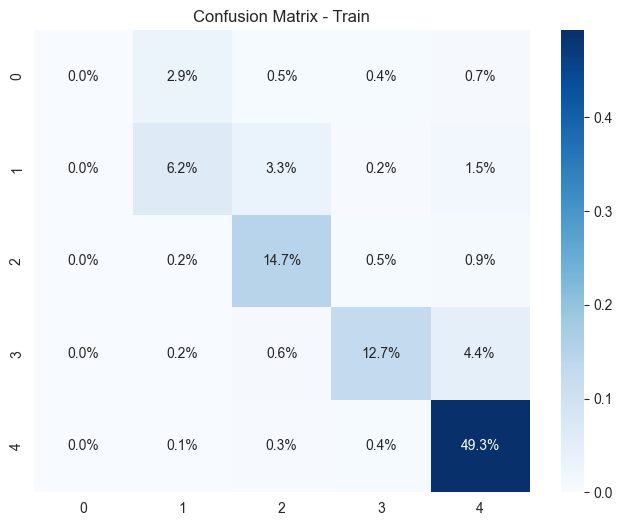

Train Accuracy: 82.9%


In [8]:
#Confusion matrix trained data
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train / np.sum(cm_train), annot=True, cmap='Blues', fmt='.1%')
plt.title("Confusion Matrix - Train")
plt.show()
print(f"Train Accuracy: {np.round(accuracy_score(y_train, y_train_pred) * 100, 1)}%")

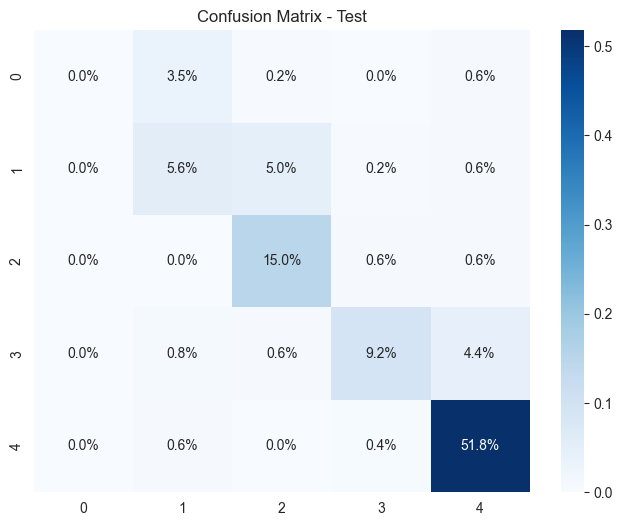

Test Accuracy: 81.6%


In [9]:
#Confusion matrix test data
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test / np.sum(cm_test), annot=True, cmap='Blues', fmt='.1%')
plt.title("Confusion Matrix - Test")
plt.show()
print(f"Test Accuracy: {np.round(accuracy_score(y_test, y_test_pred) * 100, 1)}%")

In [10]:
#Model 2 Random Forest
# Train and fit Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled[["StudyTimeWeekly", "GPA"]], y_train)

#Predict
rf_train_pred = rf_model.predict(X_train_scaled[["StudyTimeWeekly", "GPA"]])
rf_test_pred = rf_model.predict(X_test_scaled[["StudyTimeWeekly", "GPA"]])

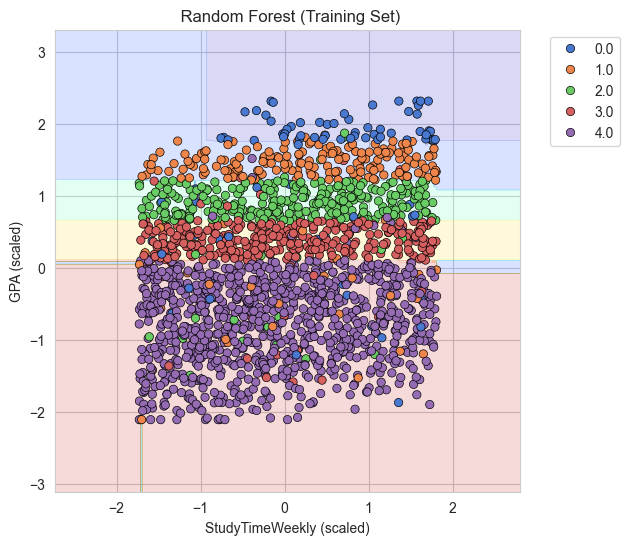

In [11]:
#Plotting the data training set
fig, ax = plt.subplots(figsize=(6, 6))
X1, X2 = np.meshgrid(
    np.arange(start=X_train_scaled["StudyTimeWeekly"].min() - 1, 
              stop=X_train_scaled["StudyTimeWeekly"].max() + 1, 
              step=0.01),
    np.arange(start=X_train_scaled["GPA"].min() - 1, 
              stop=X_train_scaled["GPA"].max() + 1, 
              step=0.01)
)
df_mesh = pd.DataFrame({
    "StudyTimeWeekly": X1.ravel(),
    "GPA": X2.ravel()
})
mesh_pred = rf_model.predict(df_mesh)
ax.contourf(X1, X2, mesh_pred.reshape(X1.shape), alpha=0.15, cmap=plt.cm.jet)

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

df_train = X_train_scaled.copy()
df_train["GradeClass"] = y_train

sns.scatterplot(x="StudyTimeWeekly", 
                y="GPA", 
                hue="GradeClass", 
                data=df_train, 
                ax=ax, 
                edgecolor='black', 
                palette="muted")
plt.title(' Random Forest (Training Set)')
plt.xlabel('StudyTimeWeekly (scaled)')
plt.ylabel('GPA (scaled)')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

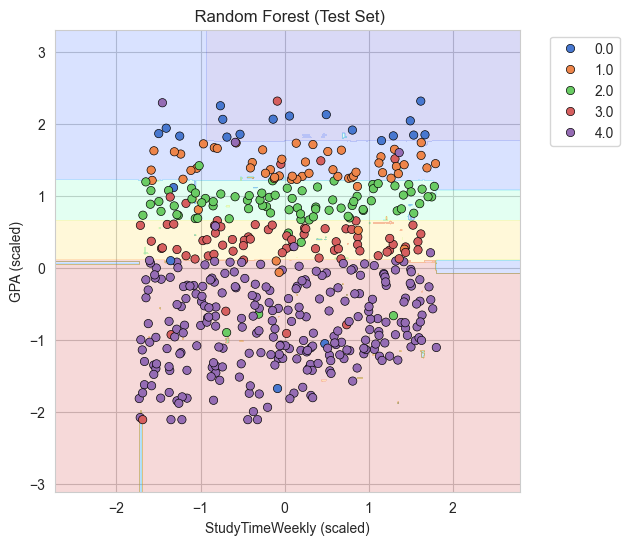

In [12]:
#Plotting the data test set
fig, ax = plt.subplots(figsize=(6, 6))
X1, X2 = np.meshgrid(
    np.arange(start=X_test_scaled["StudyTimeWeekly"].min() - 1, 
              stop=X_test_scaled["StudyTimeWeekly"].max() + 1, 
              step=0.01),
    np.arange(start=X_test_scaled["GPA"].min() - 1, 
              stop=X_test_scaled["GPA"].max() + 1, 
              step=0.01)
)
df_mesh = pd.DataFrame({
    "StudyTimeWeekly": X1.ravel(),
    "GPA": X2.ravel()
})

mesh_pred = rf_model.predict(df_mesh)

ax.contourf(X1, X2, mesh_pred.reshape(X1.shape), 
            alpha=0.15, 
            cmap=plt.cm.jet)

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

df_test = X_test_scaled.copy()
df_test["GradeClass"] = y_test

sns.scatterplot(x="StudyTimeWeekly", y="GPA", hue="GradeClass", data=df_test, ax=ax, edgecolor='black', palette="muted")
plt.title(' Random Forest (Test Set)')
plt.xlabel('StudyTimeWeekly (scaled)')
plt.ylabel('GPA (scaled)')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [13]:
# Evaluation
rf_train_pred = rf_model.predict(X_train_scaled[selected_features])
rf_test_pred = rf_model.predict(X_test_scaled[selected_features])

print("Train Accuracy:", round(accuracy_score(y_train, rf_train_pred) * 100, 1), "%")
print("Test Accuracy:", round(accuracy_score(y_test, rf_test_pred) * 100, 1), "%")

Train Accuracy: 99.9 %
Test Accuracy: 91.9 %


In [14]:
import joblib

# Save the model
joblib.dump(rf_model, "rf_model.pkl")

# Save the scaler too
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

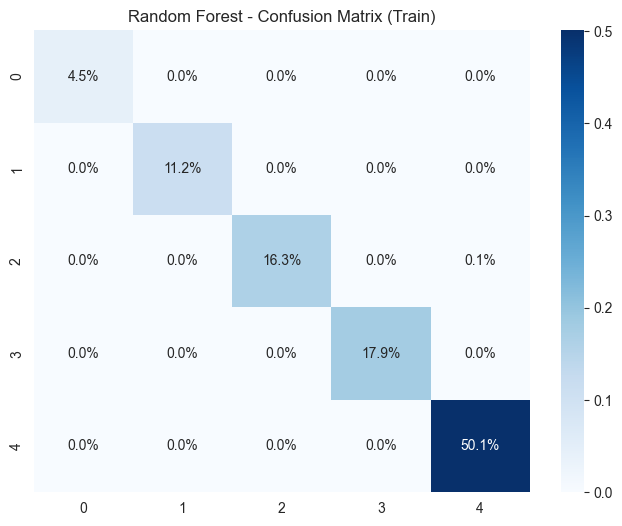

In [15]:
#Confusion matrix trained data
sns.heatmap(confusion_matrix(y_train, rf_train_pred)/np.sum(confusion_matrix(y_train, rf_train_pred)), annot=True, cmap="Blues", fmt=".1%")
plt.title("Random Forest - Confusion Matrix (Train)")
plt.show()

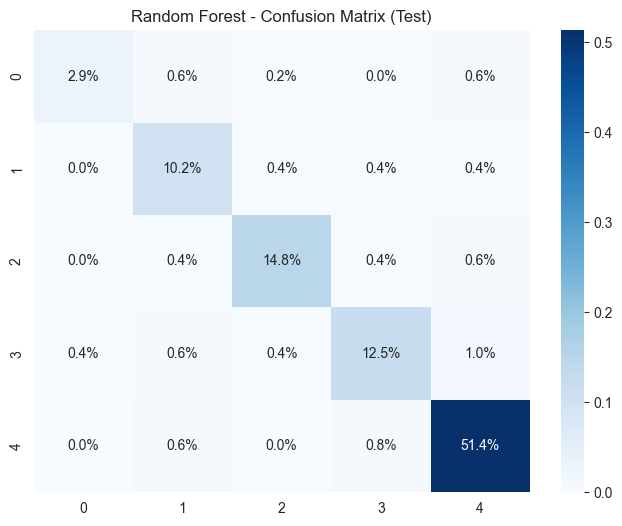

In [16]:
#Confusion matrix test data
sns.heatmap(confusion_matrix(y_test, rf_test_pred)/np.sum(confusion_matrix(y_test, rf_test_pred)), annot=True, cmap="Blues", fmt=".1%")
plt.title("Random Forest - Confusion Matrix (Test)")
plt.show()

In [17]:
#Model 3 XGBoost
# Train and fit XGBoost
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss',random_state=42)
xgb_model.fit(X_train_scaled[["StudyTimeWeekly", "GPA"]], y_train)

#Predict
xgb_train_pred = xgb_model.predict(X_train_scaled[["StudyTimeWeekly", "GPA"]])
xgb_test_pred = xgb_model.predict(X_test_scaled[["StudyTimeWeekly", "GPA"]])

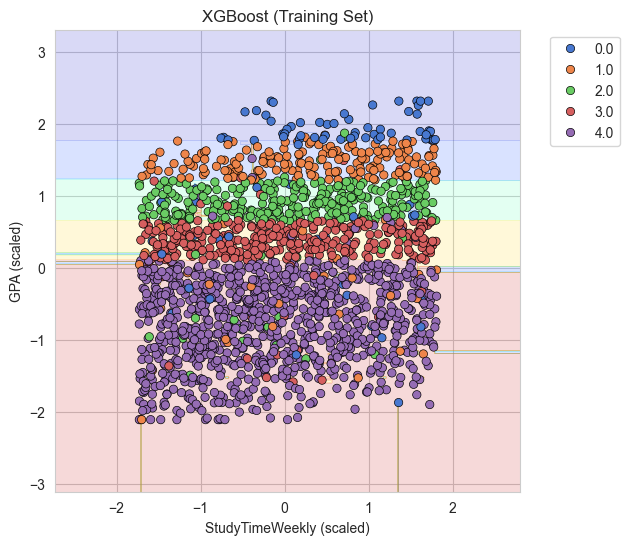

In [18]:
#Plotting the data training set
fig, ax = plt.subplots(figsize=(6, 6))
X1, X2 = np.meshgrid(
    np.arange(start=X_train_scaled["StudyTimeWeekly"].min() - 1, 
              stop=X_train_scaled["StudyTimeWeekly"].max() + 1, 
              step=0.01),
    np.arange(start=X_train_scaled["GPA"].min() - 1, 
              stop=X_train_scaled["GPA"].max() + 1, 
              step=0.01)
)
df_mesh = pd.DataFrame({
    "StudyTimeWeekly": X1.ravel(),
    "GPA": X2.ravel()
})
mesh_pred = xgb_model.predict(df_mesh)
ax.contourf(X1, X2, mesh_pred.reshape(X1.shape), alpha=0.15, cmap=plt.cm.jet)

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

df_train = X_train_scaled.copy()
df_train["GradeClass"] = y_train

sns.scatterplot(x="StudyTimeWeekly", 
                y="GPA", 
                hue="GradeClass", 
                data=df_train, 
                ax=ax, 
                edgecolor='black', 
                palette="muted")
plt.title('XGBoost (Training Set)')
plt.xlabel('StudyTimeWeekly (scaled)')
plt.ylabel('GPA (scaled)')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

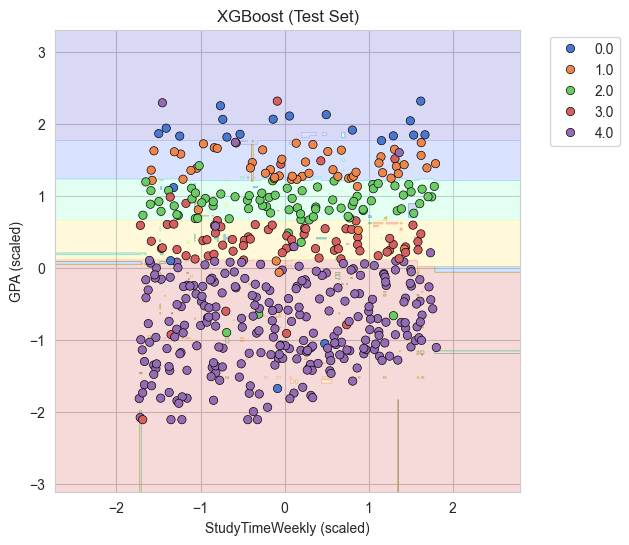

In [19]:
#Plotting the data test set
fig, ax = plt.subplots(figsize=(6, 6))
X1, X2 = np.meshgrid(
    np.arange(start=X_test_scaled["StudyTimeWeekly"].min() - 1, 
              stop=X_test_scaled["StudyTimeWeekly"].max() + 1, 
              step=0.01),
    np.arange(start=X_test_scaled["GPA"].min() - 1, 
              stop=X_test_scaled["GPA"].max() + 1, 
              step=0.01)
)
df_mesh = pd.DataFrame({
    "StudyTimeWeekly": X1.ravel(),
    "GPA": X2.ravel()
})

mesh_pred = xgb_model.predict(df_mesh)

ax.contourf(X1, X2, mesh_pred.reshape(X1.shape), 
            alpha=0.15, 
            cmap=plt.cm.jet)

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

df_test = X_test_scaled.copy()
df_test["GradeClass"] = y_test

sns.scatterplot(x="StudyTimeWeekly", y="GPA", hue="GradeClass", data=df_test, ax=ax, edgecolor='black', palette="muted")
plt.title('XGBoost (Test Set)')
plt.xlabel('StudyTimeWeekly (scaled)')
plt.ylabel('GPA (scaled)')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [20]:
#Evaluation
xgb_train_pred = xgb_model.predict(X_train_scaled[selected_features])
xgb_test_pred = xgb_model.predict(X_test_scaled[selected_features])

print("Train Accuracy:", round(accuracy_score(y_train, xgb_train_pred) * 100, 1), "%")
print("Test Accuracy:", round(accuracy_score(y_test, xgb_test_pred) * 100, 1), "%")

Train Accuracy: 99.5 %
Test Accuracy: 91.2 %


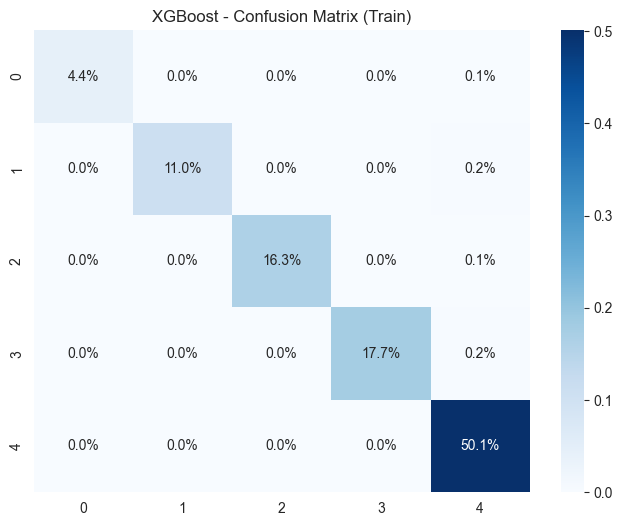

In [21]:
#Confusion matrix train data
sns.heatmap(confusion_matrix(y_train, xgb_train_pred)/np.sum(confusion_matrix(y_train, xgb_train_pred)), annot=True, cmap="Blues", fmt=".1%")
plt.title("XGBoost - Confusion Matrix (Train)")
plt.show()

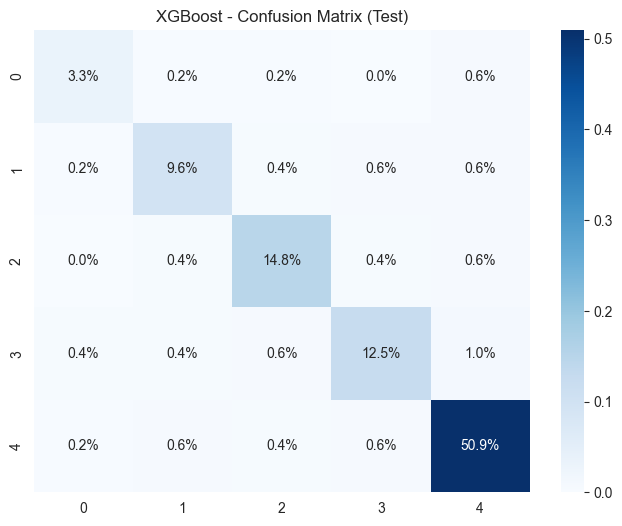

In [22]:
#Confusion matrix test data
sns.heatmap(confusion_matrix(y_test, xgb_test_pred)/np.sum(confusion_matrix(y_test, xgb_test_pred)), annot=True, cmap="Blues", fmt=".1%")
plt.title("XGBoost - Confusion Matrix (Test)")
plt.show()

In [23]:
#Model 4 MLPClassifier
# Train and fit MLPClassifier
mlp_model = MLPClassifier(max_iter=500, random_state=42)
mlp_model.fit(X_train_scaled[["StudyTimeWeekly", "GPA"]], y_train)

#Predict
mlp_train_pred = mlp_model.predict(X_train_scaled[["StudyTimeWeekly", "GPA"]])
mlp_test_pred = mlp_model.predict(X_test_scaled[["StudyTimeWeekly", "GPA"]])

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


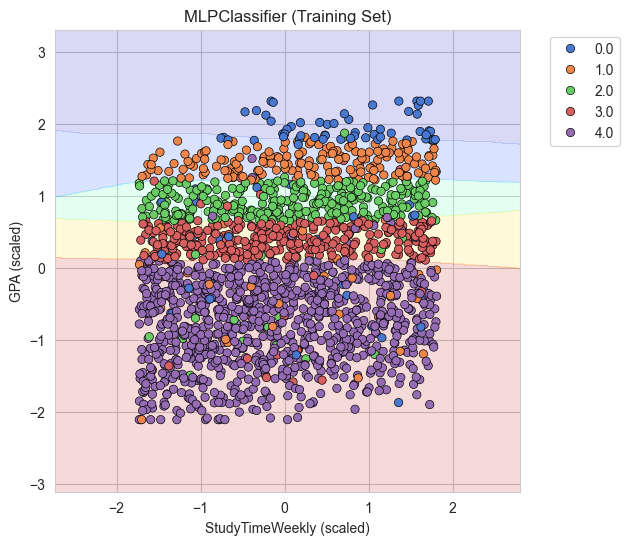

In [24]:
#Plotting the data training set
fig, ax = plt.subplots(figsize=(6, 6))
X1, X2 = np.meshgrid(
    np.arange(start=X_train_scaled["StudyTimeWeekly"].min() - 1, 
              stop=X_train_scaled["StudyTimeWeekly"].max() + 1, 
              step=0.01),
    np.arange(start=X_train_scaled["GPA"].min() - 1, 
              stop=X_train_scaled["GPA"].max() + 1, 
              step=0.01)
)
df_mesh = pd.DataFrame({
    "StudyTimeWeekly": X1.ravel(),
    "GPA": X2.ravel()
})
mesh_pred = mlp_model.predict(df_mesh)
ax.contourf(X1, X2, mesh_pred.reshape(X1.shape), alpha=0.15, cmap=plt.cm.jet)

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

df_train = X_train_scaled.copy()
df_train["GradeClass"] = y_train

sns.scatterplot(x="StudyTimeWeekly", 
                y="GPA", 
                hue="GradeClass", 
                data=df_train, 
                ax=ax, 
                edgecolor='black', 
                palette="muted")
plt.title('MLPClassifier (Training Set)')
plt.xlabel('StudyTimeWeekly (scaled)')
plt.ylabel('GPA (scaled)')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

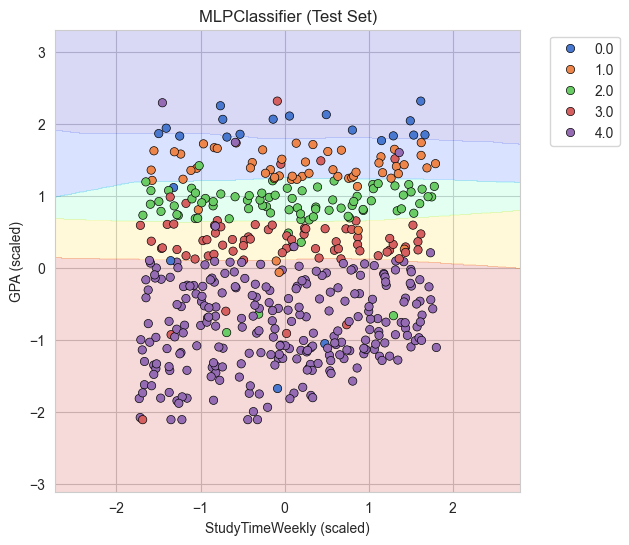

In [25]:
#Plotting the data test set
fig, ax = plt.subplots(figsize=(6, 6))
X1, X2 = np.meshgrid(
    np.arange(start=X_test_scaled["StudyTimeWeekly"].min() - 1, 
              stop=X_test_scaled["StudyTimeWeekly"].max() + 1, 
              step=0.01),
    np.arange(start=X_test_scaled["GPA"].min() - 1, 
              stop=X_test_scaled["GPA"].max() + 1, 
              step=0.01)
)
df_mesh = pd.DataFrame({
    "StudyTimeWeekly": X1.ravel(),
    "GPA": X2.ravel()
})

mesh_pred = mlp_model.predict(df_mesh)

ax.contourf(X1, X2, mesh_pred.reshape(X1.shape), 
            alpha=0.15, 
            cmap=plt.cm.jet)

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

df_test = X_test_scaled.copy()
df_test["GradeClass"] = y_test

sns.scatterplot(x="StudyTimeWeekly", y="GPA", hue="GradeClass", data=df_test, ax=ax, edgecolor='black', palette="muted")
plt.title('MLPClassifier (Test Set)')
plt.xlabel('StudyTimeWeekly (scaled)')
plt.ylabel('GPA (scaled)')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [26]:
#Evaluation
mlp_train_pred = mlp_model.predict(X_train_scaled[selected_features])
mlp_test_pred = mlp_model.predict(X_test_scaled[selected_features])

print("Train Accuracy:", round(accuracy_score(y_train, mlp_train_pred) * 100, 1), "%")
print("Test Accuracy:", round(accuracy_score(y_test, mlp_test_pred) * 100, 1), "%")

Train Accuracy: 91.4 %
Test Accuracy: 91.0 %


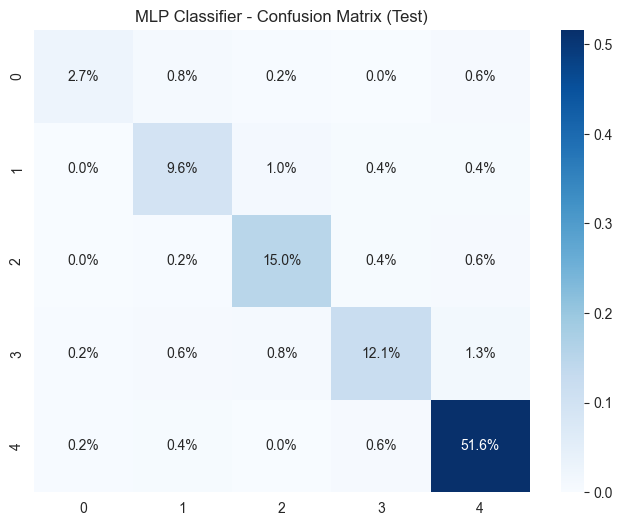

In [27]:
#Confusion matrix test data
sns.heatmap(confusion_matrix(y_test, mlp_test_pred)/np.sum(confusion_matrix(y_test, mlp_test_pred)), annot=True, cmap="Blues", fmt=".1%")
plt.title("MLP Classifier - Confusion Matrix (Test)")
plt.show()

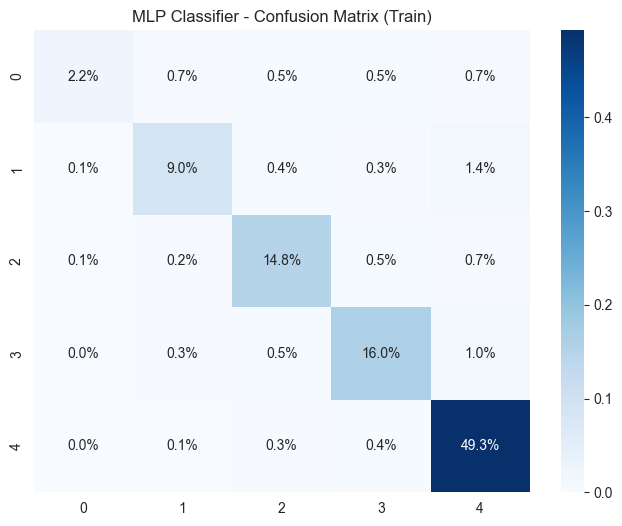

In [28]:
#Confusion matrix train data
sns.heatmap(confusion_matrix(y_train, mlp_train_pred)/np.sum(confusion_matrix(y_train, mlp_train_pred)), annot=True, cmap="Blues", fmt=".1%")
plt.title("MLP Classifier - Confusion Matrix (Train)")
plt.show()

Model Accuracy Summary:
                 Model  Train Accuracy  Test Accuracy
0  Logistic Regression        0.829064       0.816284
1        Random Forest        0.999477       0.918580
2              XGBoost        0.994773       0.912317
3        MLPClassifier        0.914271       0.910230


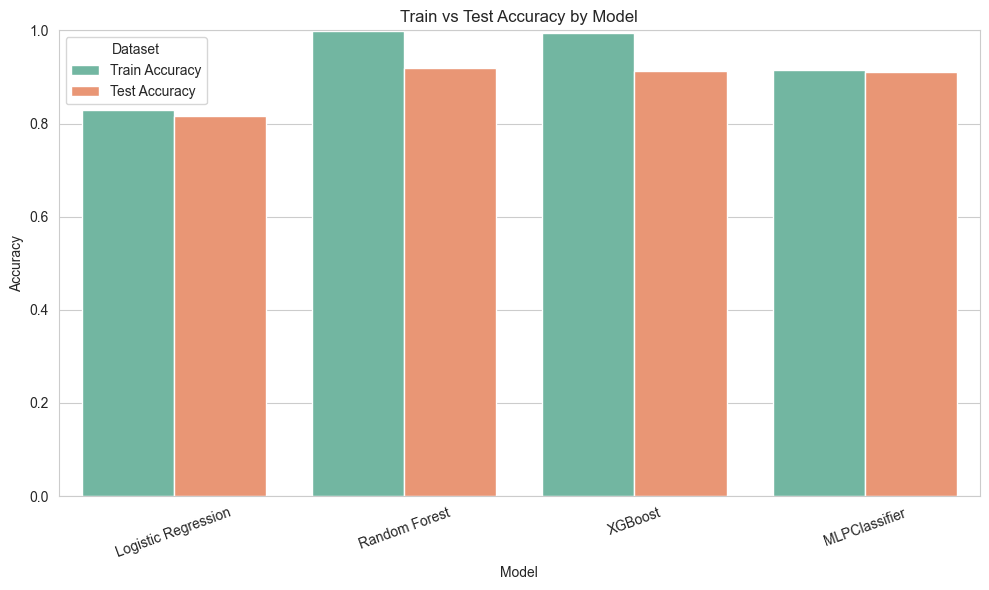

In [29]:
#accuracy scores
summaryData = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'MLPClassifier'],
    'Train Accuracy': [
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_train, rf_train_pred),
        accuracy_score(y_train, xgb_train_pred),
        accuracy_score(y_train, mlp_train_pred)
    ],
    'Test Accuracy': [
        accuracy_score(y_test, y_test_pred),
        accuracy_score(y_test, rf_test_pred),
        accuracy_score(y_test, xgb_test_pred),
        accuracy_score(y_test, mlp_test_pred)
    ]
}

# Create a DataFrame
summary_df = pd.DataFrame(summaryData)

print("Model Accuracy Summary:")
print(summary_df)

# Plotting the results
plt.figure(figsize=(10, 6))
sns.barplot(data=pd.melt(summary_df, id_vars='Model', var_name='Dataset', value_name='Accuracy'),
            x='Model', y='Accuracy', hue='Dataset', palette='Set2')

plt.title('Train vs Test Accuracy by Model')
plt.ylim(0, 1)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()